In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn import metrics 
import tqdm
import os
import sys
# sys.path.insert(0, '')
import importlib
from dredFISH.Analysis import basicu
from dredFISH.Analysis import powerplots

importlib.reload(basicu)

sns.set_context('talk')

In [28]:
fig_dir = '/bigstore/GeneralStorage/fangming/projects/visctx/figures/'
data_dir = '/bigstore/GeneralStorage/fangming/projects/visctx/data_dump/'

# Load data

In [3]:
f = '../data_dump/candidate_genes_vincent_0503_v2.csv'
df0 = pd.read_csv(f)
df0 = df0.sort_values(['Subclass', 'Type/Gradient'])
df0 = df0[df0['Allen marker'].isnull()]
df0 = df0[df0['Gene']!='Neurod1']
df0 = df0.set_index('Gene')
df0

,Subclass,Type/Gradient,Function,Priority,Allen marker
Gene,,,,,
Baz1a,L2/3,A<B>C,TF,***,NaN
Bdnf,L2/3,A<B>C,CAM,***,NaN
Cdh4,L2/3,A<B>C,CAM,***,NaN
Epha3,L2/3,A<B>C,CAM,***,NaN
Grm8,L2/3,A<B>C,IC,NaN,NaN
...,...,...,...,...,...
Gria3,L2/3,all,IC,NaN,NaN
Ptpru,L2/3,all,CAM,NaN,NaN
Stard8,L2/3,all,other,NaN,NaN


In [4]:
%%time
adata = ad.read('../data_dump/P38_glut_genes_v3.h5ad')
adata

CPU times: user 120 ms, sys: 128 ms, total: 249 ms
Wall time: 247 ms


AnnData object with n_obs × n_vars = 5837 × 83
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Type_colors', 'cluster_colors', "dendrogram_['leiden']", 'hvg', 'layer_colors', 'leiden', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
# select the non-allen genes
adata = adata[:,df0.index.values]

In [6]:
# zscore
adata.X = basicu.zscore(adata.X, axis=0)
adata.X.mean(axis=0), adata.X.std(axis=0)

(ArrayView([-7.84244758e-09,  1.82990441e-08, -1.30707467e-09,
            -1.56848952e-08, -4.83617590e-08, -1.43778207e-08,
             1.82990441e-08,  5.22829868e-09, -4.37870007e-08,
             2.48344172e-08,  3.26768657e-09,  1.04565974e-08,
            -8.62669225e-08,  5.65309755e-08, -1.73187384e-08,
            -7.84244758e-09,  1.50313575e-08, -1.17636718e-08,
            -4.50940725e-08,  5.75112828e-08,  3.92122379e-09,
            -6.53537313e-09,  2.54879549e-08,  8.49598525e-09,
            -2.35273436e-08,  2.61414925e-08, -2.74485661e-08,
            -1.17636718e-08, -8.16921641e-10,  5.22829868e-09,
             3.26768657e-08, -1.90179350e-07,  5.22829868e-09,
             1.17636718e-08, -3.92122379e-09,  4.57476119e-08,
            -5.27731387e-08,  3.33304015e-08, -4.57476101e-09,
             2.61414934e-09, -1.85604591e-07,  5.22829868e-09,
            -2.77753358e-08, -1.40510519e-08,  9.14952203e-09,
             5.22829868e-09,  6.53537313e-09,  1.029321

## cluster level profiles

In [7]:
Xk, xclsts = basicu.group_mean(adata.X, adata.obs['cluster'])
Xk = np.array(Xk)
Xk = pd.DataFrame(Xk, index=xclsts, columns=adata.var.index)
Xk.shape, xclsts.shape, xclsts

((6, 69),
 (6,),
 array(['L2/3_A', 'L2/3_B', 'L2/3_C', 'L4_A', 'L4_B', 'L4_C'], dtype=object))

### classsification based off the ~86 genes (Try LASSO for the minimum set of genes)
- L2/3 vs L4
- L2/3 subtypes
- continuum (UMAP_1 as a proxy)

In [8]:
def get_precision_recall(y_true, y_pred):
    """Auto system; has some edge case issues
    """
    p, r, th = metrics.precision_recall_curve(y_true, y_pred)
    # pidx = np.argsort(p)
    # p = p[pidx]
    # r = r[pidx]
    # p = np.hstack([0, p, 1])
    # r = np.hstack([1, r, 0])
    return p, r

def get_precision_recall_v2(y_true, y_pred):
    """Auto system; has some edge case issues
    """
    pth = np.linspace(0,1,101)
    p = []
    r = []
    for pth1 in pth:
        conf = metrics.confusion_matrix(y_true, y_pred>pth)
        tn, fp, fn, tp = conf.ravel()
        p1 = tp/(tp+fp)
        r1 = tp/(tp+fn)
        p.append(p1)
        r.append(r1)
    
    return p, r

def evaluate(y_true, y_pred, pr_opt='v1'):
    """
    """
    # evaluation
    if pr_opt == 'v1':
        p, r = get_precision_recall(y_true, y_pred)
    elif pr_opt == 'v2':
        p, r = get_precision_recall_v2(y_true, y_pred)
    aupr = metrics.auc(r, p)
    # aupr = -1
    return p, r, aupr

def classifier_pipe(X, y, c=1):
    """
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    ps = []
    rs = []
    auprs = []
    
    y_true = np.empty(len(y))
    y_pred = np.empty(len(y))
    
    
    l0s = []
    l1s = []
    for train_idx, test_idx, in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # train
        model = LogisticRegression(penalty='l1', solver='liblinear', C=c, random_state=0)
        # model = LogisticRegression(random_state=0)
        model.fit(X_train, y_train)
        
        # test
        yp = model.predict_proba(X_test)
        
        # results
        l0 = (np.abs(model.coef_) > 1e-6).sum() 
        l1 = np.abs(model.coef_).sum()
        l0s.append(l0)
        l1s.append(l1)
        
        # results
        y_true[test_idx] = y_test.values.astype(int)
        y_pred[test_idx] = yp[:,1]
        
        
    return y_true, y_pred, l0s, l1s

def plot_pipe(ax, y_true, y_pred, pr_opt='v1'):
    """
    """
    ps, rs, aupr = evaluate(y_true, y_pred, pr_opt=pr_opt) 
    
    ax.plot(rs, ps, color='C0', linewidth=2)
    ax.text(0,0.1, f"AUPR={aupr:.2f}")
    sns.despine(ax=ax)
    ax.set_aspect('equal')
    ax.set_xticks(np.linspace(0,1,6))
    ax.set_yticks(np.linspace(0,1,6))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    return ax

In [9]:
def classifier_tuning(X, y, Cs):
    """
    """
    res = []
    ressum = []
    for c in tqdm.tqdm(Cs):
        # run
        y_true, y_pred, l0s, l1s = classifier_pipe(X, y, c=c)
        p, r, aupr = evaluate(y_true, y_pred)
        res.append((y_true, y_pred, l0s, l1s))
        ressum.append({
           'C': c,
           'AUPR': aupr,
           'coef L0': np.mean(l0s),
           'coef L1': np.mean(l1s),
          })

    ressum = pd.DataFrame(ressum)
    return res, ressum

def plot_ressum(ressum, scale='linear', title=''):
    """
    """
    fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
    ax = axs[0]
    ax.plot(ressum['C'], ressum['coef L0'], '-o')
    ax.set_ylabel('# genes used')
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    ax.set_title(title)
    
    ax = axs[1]
    ax.plot(ressum['C'], ressum['AUPR'], '-o')
    ax.set_ylabel('AUPR')
    ax.set_xlabel('Regularization')
    ax.set_ylim(ymax=1.02)
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    if scale == 'linear':
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
    
    plt.show()
    
def plot_multi_ressum(ressum, scale='linear', title=''):
    """
    """
    fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
    ax = axs[0]
    ax.plot(ressum['C'], ressum['coef L0'], '-o')
    ax.set_ylabel('# genes used')
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    ax.set_title(title)
    
    ax = axs[1]
    ax.plot(ressum['C'], ressum['AUPR'], '-o')
    ax.set_ylabel('AUPR')
    ax.set_xlabel('Regularization')
    ax.set_ylim(ymax=1.02)
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    if scale == 'linear':
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
    
    plt.show()
    
def plot_res(res, Cs, suptitle=''):
    """
    """
    n = len(Cs)
    nx = 5
    ny = int((n+nx-1)/nx)

    fig, axs = plt.subplots(ny,nx,figsize=(5*nx,5*ny))
    for i, (oneres, c, ax) in enumerate(zip(res, Cs, axs.flat)):
        y_true, y_pred, _, _ = oneres
        plot_pipe(ax, y_true, y_pred, pr_opt='v1')
        ax.set_title(f'C = {c:.2g}')

    for ax in axs.flat[i+1:]:
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    fig.suptitle(suptitle, fontsize=20)
    plt.show()

In [10]:
def get_model_used_genes(model, allgenes):
    """
    """
    abscoef = np.abs(model.coef_.reshape(-1,))
    cond = abscoef > 1e-6 
    
    if cond.sum() > 0:
        used_abscoef = abscoef[cond]
        used_genes = allgenes[cond]
        used_coefidx = np.argsort(used_abscoef)[::-1]

        return used_abscoef[used_coefidx], used_genes[used_coefidx]
    else:
        return 0,0

In [11]:
def plot_heatmap(Xplot, Xannot, xlabel='', title='', figsize=(8,5)):
    """
    """
    mosaic = "A"*10+"BCDE"
    fig, axs = plt.subplot_mosaic(mosaic, figsize=figsize)
    ax = axs['A']
    sns.heatmap(Xplot, 
                xticklabels=True,
                yticklabels=True,
                cmap='coolwarm', 
                cbar_kws=dict(shrink=0.3, label='Mean gene expression (normed)', location='left', pad=0.3),
                ax=ax)
    ax.axvline(3, color='gray', linewidth=1)
    ax.set_yticklabels(ax.get_yticklabels(), 
                       # fontsize=10, 
                       rotation=0)
    ax.set_xlabel(xlabel)

    for i, ax in enumerate([axs['B'], axs['C'], axs['D'], axs['E']]):
        nums, catgs = pd.factorize(Xannot.iloc[:,i])
        # ax.set_title(Xannot.columns[i], fontsize=12, rotation=90)
        sns.heatmap(nums.reshape(-1,1), 
                    annot=pd.Series(catgs.values[nums]).values.reshape(-1,1),
                    annot_kws={'size': 10},
                    yticklabels=False,
                    # xticklabels=False,
                    fmt='',
                    cbar=False,
                    cmap='jet',
                    ax=ax
                   )
        ax.set_xticklabels([Xannot.columns[i]], rotation=90)
    fig.suptitle(title)
    plt.show()

In [12]:
def plot_multi_ressum(ressum_list, scale='linear', title=''):
    """
    """
    fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
    ax = axs[0]
    for ressum in ressum_list:
        ax.plot(ressum['C'], ressum['coef L0'], '-o')
        ax.set_ylabel('# genes used')
        ax.grid()
        sns.despine(ax=ax)
        ax.set_xscale(scale)
        ax.set_title(title)

    ax = axs[1]
    for ressum in ressum_list:
        ax.plot(ressum['C'], ressum['AUPR'], '-o')
        ax.set_ylabel('AUPR')
        ax.set_xlabel('Regularization')
        ax.set_ylim(ymax=1.02)
        ax.grid()
        sns.despine(ax=ax)
        ax.set_xscale(scale)
        if scale == 'linear':
            ax.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
    
    plt.show()
    
def plot_multi_ressum_v2(ressum_list, labels, colors, scale='linear', title=''):
    """
    """
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    for ressum, label, color in zip(ressum_list, labels, colors):
        ax.plot(ressum['coef L0'], ressum['AUPR'], '-o', markersize=6, 
                label=label,
                color=color,
               )
        
    ax.grid(False)
    ax.set_title(title)
    sns.despine(ax=ax)
    ax.set_xlim([-1, 21])
    # ax.set_ylim([0.5, 1.02])
    ax.set_xlabel('# genes used')
    ax.set_ylabel('AUPR')
    
    ax.legend(bbox_to_anchor=(1,1), loc='upper left') 
    # ax.set_xscale(scale)
    return fig

In [13]:
def identify_used_genes_pipe(adata, col, cluster, model):
    """
    """
    # data
    X = adata.X
    if len(cluster) > 0:
        y = adata.obs[col].str.contains(cluster)
    else:
        y = adata.obs[col].values
        
    allgenes = adata.var.index.values

    model.fit(X, y)
    absweights, ugenes = get_model_used_genes(model, allgenes)
    print(len(ugenes), absweights, ugenes)
    return absweights, ugenes

# comparisons

In [14]:
# data
X = adata.X
y = adata.obs['cluster'].str.contains('L2/3')
print(X.shape, y.shape)

(5837, 69) (5837,)


[0.0001 0.0002 0.0003 0.0004 0.0005 0.0006 0.0007 0.0008 0.0009 0.001
 0.01   0.1   ]


100%|██████████| 12/12 [00:01<00:00,  6.48it/s]


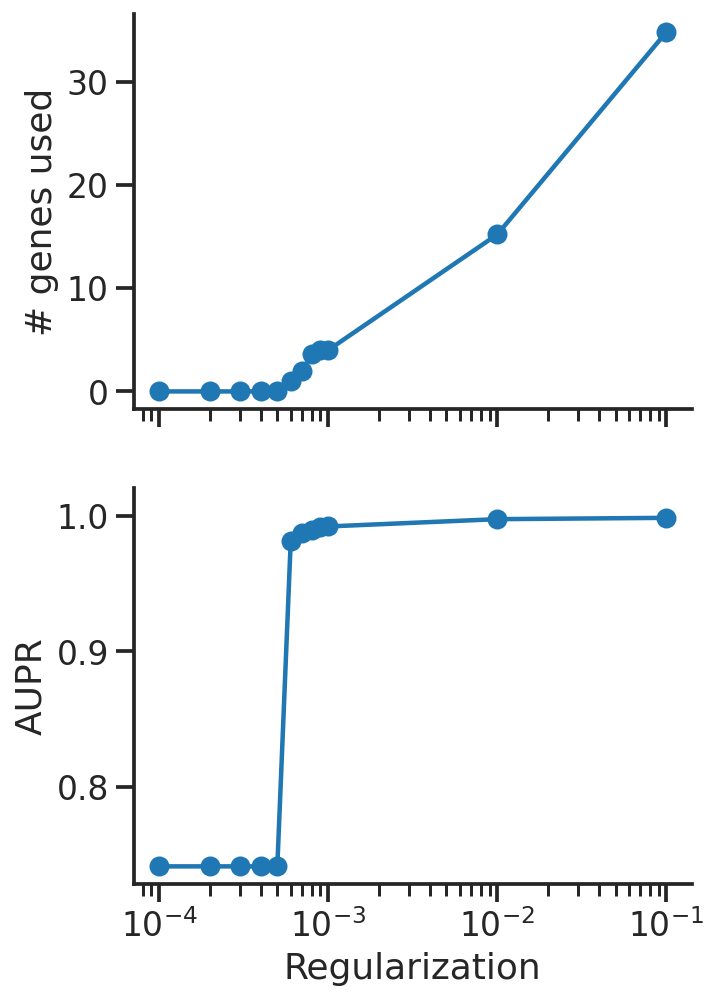

In [15]:
# Cs = np.linspace(4e-4, 5e-4, 11) # micro
# Cs = np.logspace(-4, 1, 6) # macro

Cs = np.linspace(1e-4, 1e-3, 10) # macro
Cs = np.hstack([Cs, [1e-2, 1e-1]])
print(Cs)
res, ressum = classifier_tuning(X, y, Cs)
plot_ressum(ressum, scale='log')
# plot_res(res, Cs)

In [16]:
# data
cond = adata.obs['cluster'].str.contains('L2/3')
adatasub = adata[cond].copy()
X = adatasub.X

y_a = adatasub.obs['cluster'].str.contains('L2/3_A') 
y_b = adatasub.obs['cluster'].str.contains('L2/3_B') 
y_c = adatasub.obs['cluster'].str.contains('L2/3_C') 
print(X.shape, y_a.shape, y_b.shape, y_c.shape)

(2818, 69) (2818,) (2818,) (2818,)


[1.00000000e-04 1.62377674e-04 2.63665090e-04 4.28133240e-04
 6.95192796e-04 1.12883789e-03 1.83298071e-03 2.97635144e-03
 4.83293024e-03 7.84759970e-03 1.27427499e-02 2.06913808e-02
 3.35981829e-02 5.45559478e-02 8.85866790e-02 1.43844989e-01
 2.33572147e-01 3.79269019e-01 6.15848211e-01 1.00000000e+00]


100%|██████████| 20/20 [00:04<00:00,  4.78it/s]


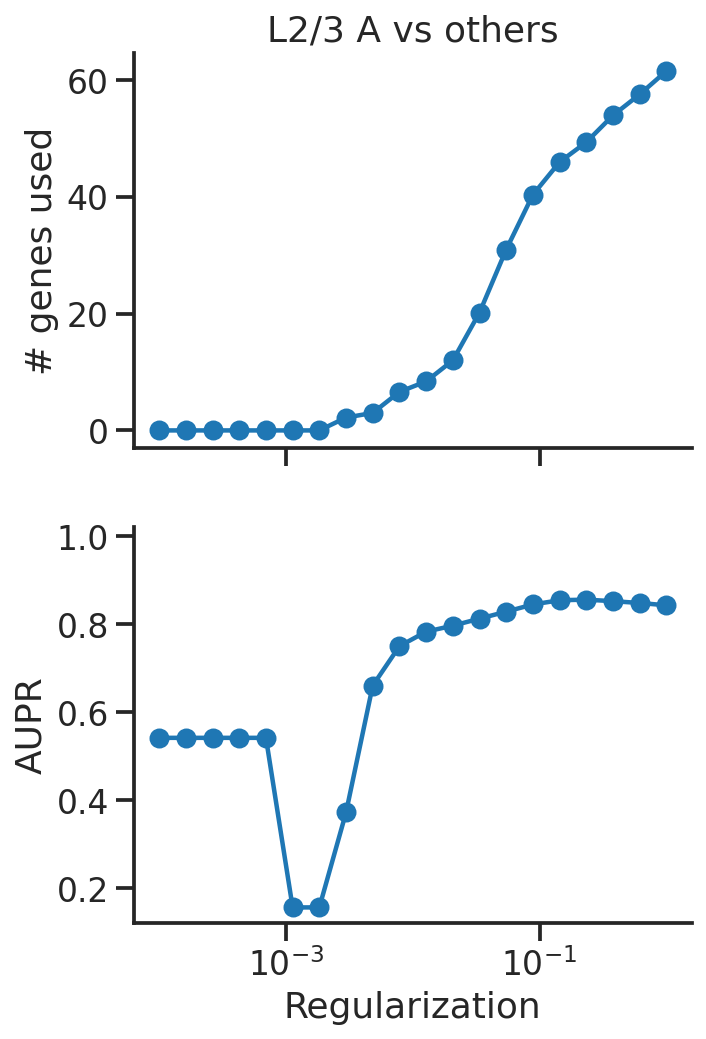

In [17]:
title = 'L2/3 A vs others'
Cs = np.logspace(-4, 0, 20) # macro
print(Cs)
res_a, ressum_a = classifier_tuning(X, y_a, Cs)
plot_ressum(ressum_a, scale='log', title=title)
# plot_res(res_a, Cs, suptitle=title)

[1.00000000e-04 1.58489319e-04 2.51188643e-04 3.98107171e-04
 6.30957344e-04 1.00000000e-03 1.58489319e-03 2.51188643e-03
 3.98107171e-03 6.30957344e-03 1.00000000e-02 1.58489319e-02
 2.51188643e-02 3.98107171e-02 6.30957344e-02 1.00000000e-01
 1.58489319e-01 2.51188643e-01 3.98107171e-01 6.30957344e-01
 1.00000000e+00]


100%|██████████| 21/21 [00:01<00:00, 11.99it/s]


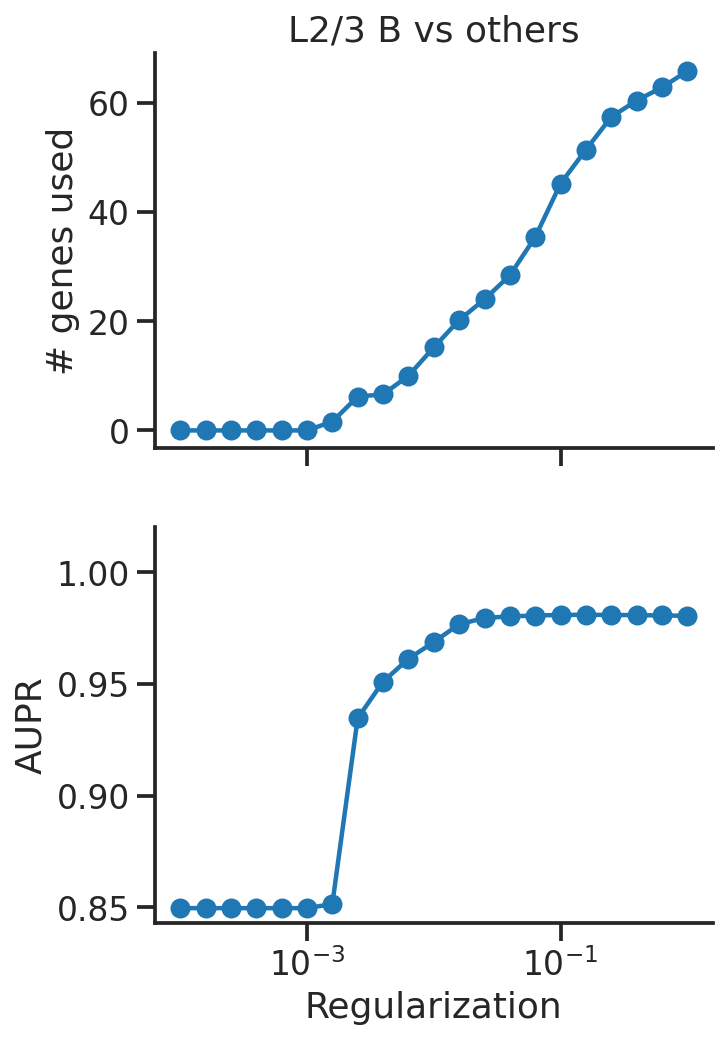

In [18]:
title = 'L2/3 B vs others'
Cs = np.logspace(-4, 0, 21) # macro
print(Cs)
res_b, ressum_b = classifier_tuning(X, y_b, Cs)
plot_ressum(ressum_b, scale='log', title=title)
# plot_res(res_b, Cs, suptitle=title)

[1.00000000e-04 1.58489319e-04 2.51188643e-04 3.98107171e-04
 6.30957344e-04 1.00000000e-03 1.58489319e-03 2.51188643e-03
 3.98107171e-03 6.30957344e-03 1.00000000e-02 1.58489319e-02
 2.51188643e-02 3.98107171e-02 6.30957344e-02 1.00000000e-01
 1.58489319e-01 2.51188643e-01 3.98107171e-01 6.30957344e-01
 1.00000000e+00]


100%|██████████| 21/21 [00:01<00:00, 13.03it/s]


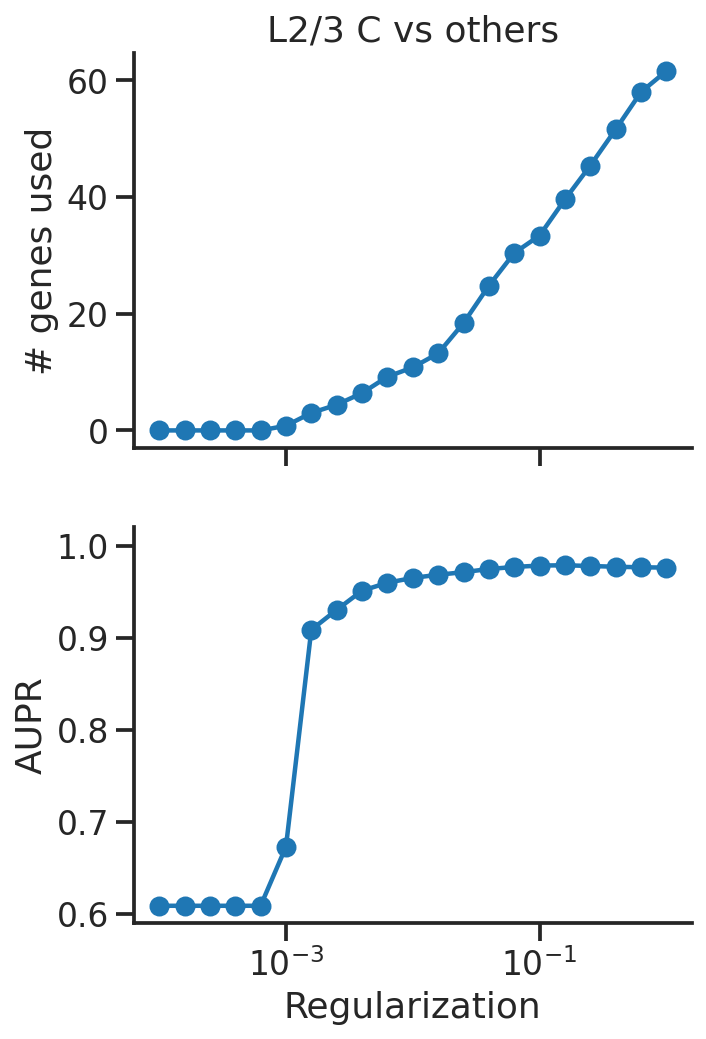

In [19]:
title = 'L2/3 C vs others'
Cs = np.logspace(-4, 0, 21) # macro
print(Cs)
res_c, ressum_c = classifier_tuning(X, y_c, Cs)
plot_ressum(ressum_c, scale='log', title=title)
# plot_res(res_c, Cs, suptitle=title)

# Overall LASSO performance

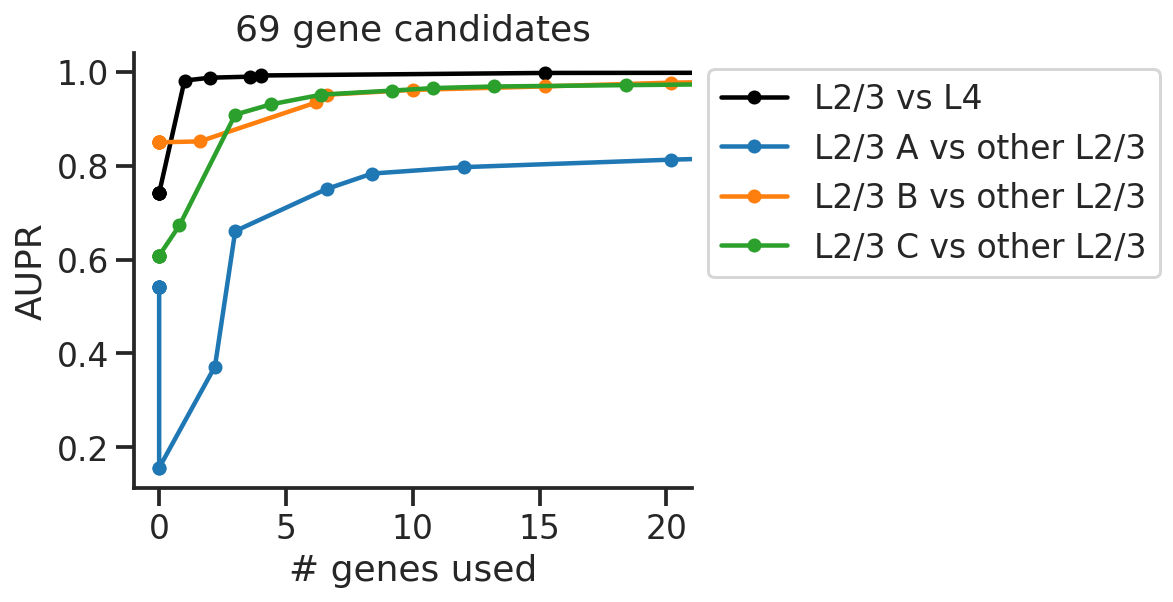

In [20]:
fig = plot_multi_ressum_v2([ressum, ressum_a, ressum_b, ressum_c], 
                         ['L2/3 vs L4', 'L2/3 A vs other L2/3', 'L2/3 B vs other L2/3', 'L2/3 C vs other L2/3'],
                         ['k', 'C0', 'C1', 'C2',],
                         # scale='log', 
                         title=f'{Xk.shape[1]} gene candidates',
                          )

# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_gene_vs_aupr.pdf'))

# get gene orders, select and viz

In [21]:
# L2/3 and L4 adata
# subset L2/3 only
cond = adata.obs['cluster'].str.contains('L2/3')
adatasub = adata[cond].copy()

# classification
# run L2/3 vs L4
model = LogisticRegression(penalty='l1', solver='liblinear', C=0.001, random_state=0)
absweights, ugenes_l23vsl4 = identify_used_genes_pipe(adata, 'cluster', 'L2/3', model)

# run L2/3 subtypes
model = LogisticRegression(penalty='l1', solver='liblinear', C=0.04, random_state=0)
absweights, ugenes_l23a = identify_used_genes_pipe(adatasub, 'cluster', 'L2/3_A', model)

model = LogisticRegression(penalty='l1', solver='liblinear', C=0.02, random_state=0)
absweights, ugenes_l23b = identify_used_genes_pipe(adatasub, 'cluster', 'L2/3_B', model)

model = LogisticRegression(penalty='l1', solver='liblinear', C=0.02, random_state=0)
absweights, ugenes_l23c = identify_used_genes_pipe(adatasub, 'cluster', 'L2/3_C', model)

4 [0.64509718 0.32033796 0.24433802 0.13505192] ['Gria3' 'Rorb' 'Chrm3' 'Dgkb']
31 [7.42790470e-01 5.93363734e-01 5.09457137e-01 2.49996449e-01
 1.98540135e-01 1.84501953e-01 1.74737087e-01 1.70302942e-01
 1.51662315e-01 1.51212976e-01 1.48442699e-01 1.30758658e-01
 9.85438815e-02 8.79575108e-02 7.86379538e-02 6.43702359e-02
 5.83079262e-02 5.38474041e-02 5.36316545e-02 4.21796467e-02
 3.80362453e-02 3.78783348e-02 3.28328784e-02 3.04665691e-02
 2.87256154e-02 2.81584514e-02 2.17038641e-02 1.48967388e-02
 9.41935155e-03 4.06810642e-03 2.06244366e-04] ['Cntn5' 'Sorcs3' 'Cdh12' 'Kcnq5' 'Epha6' 'Epha10' 'Rfx3' 'Stard8' 'Igfn1'
 'Ptpru' 'Mkx' 'Dgkb' 'Chrm3' 'Trpc6' 'Robo1' 'Kcnn3' 'Igsf9b' 'Met'
 'Nptx2' 'Grm8' 'Scn1a' 'Sox5' 'Sema6d' 'Otof' 'Tenm1' 'Cbln2' 'Grm1'
 'Robo3' 'Sdk2' 'Baz1a' 'Kirrel3']
24 [0.78035301 0.4752986  0.39163673 0.37561145 0.3387004  0.31281109
 0.27523202 0.2742466  0.25570668 0.23676819 0.23137952 0.22587082
 0.19910874 0.13625522 0.12321013 0.11146751 0.09395944 0

In [22]:
Xannot = Xk.T.copy()
Xannot.loc[ugenes_l23vsl4, 'LassoRank_L23vsL4'] = 1+np.arange(len(ugenes_l23vsl4))
Xannot.loc[ugenes_l23a, 'LassoRank_L23a'] = 1+np.arange(len(ugenes_l23a))
Xannot.loc[ugenes_l23b, 'LassoRank_L23b'] = 1+np.arange(len(ugenes_l23b))
Xannot.loc[ugenes_l23c, 'LassoRank_L23c'] = 1+np.arange(len(ugenes_l23c))

Xannot

,L2/3_A,L2/3_B,L2/3_C,L4_A,L4_B,L4_C,LassoRank_L23vsL4,LassoRank_L23a,LassoRank_L23b,LassoRank_L23c
Baz1a,0.335619,0.453365,0.055479,-0.330568,-0.328883,-0.338623,NaN,30.0,NaN,NaN
Bdnf,-0.122763,0.183086,-0.217823,-0.345806,0.195881,-0.089652,NaN,NaN,NaN,NaN
Cdh4,0.576217,0.391794,-0.211129,-0.316689,-0.337991,-0.162615,NaN,NaN,NaN,NaN
Epha3,1.070820,0.702344,-0.391097,-0.413579,-0.547025,-0.430795,NaN,NaN,23.0,10.0
Grm8,0.870588,0.852629,-0.403610,-0.490686,-0.571571,-0.553779,NaN,20.0,8.0,6.0
...,...,...,...,...,...,...,...,...,...,...
Gria3,0.948195,0.917759,0.670775,-0.384467,-0.979398,-0.942011,1.0,NaN,NaN,NaN
Ptpru,1.141678,-0.065918,-0.197644,0.350177,-0.151473,-0.116119,NaN,10.0,17.0,NaN
Stard8,0.021097,0.656146,0.355367,-0.578027,-0.440754,-0.500999,NaN,8.0,21.0,NaN
Chrm2,-0.857283,-0.713823,0.735762,-0.159252,0.570156,0.578179,NaN,NaN,1.0,3.0


In [23]:
cond = (
      (Xannot['LassoRank_L23vsL4'] <= 1)
    | (Xannot['LassoRank_L23a'] <= 7)
    | (Xannot['LassoRank_L23b'] <= 7)
    | (Xannot['LassoRank_L23c'] <= 7)
)
Xannot_s = Xannot[cond].sort_values([
                                     'LassoRank_L23a',
                                     'LassoRank_L23b',
                                     'LassoRank_L23c',
                                     'LassoRank_L23vsL4',
                                    ])
Xannot_s.shape

(17, 10)

In [24]:
X_s = Xannot_s.filter(regex=r'^L[0-9]').copy()
X_s['L4'] = X_s.filter(regex=r'^L4').mean(axis=1)
X_s = X_s[['L2/3_A', 'L2/3_B', 'L2/3_C', 'L4',]]
print(X_s.shape)

(17, 4)


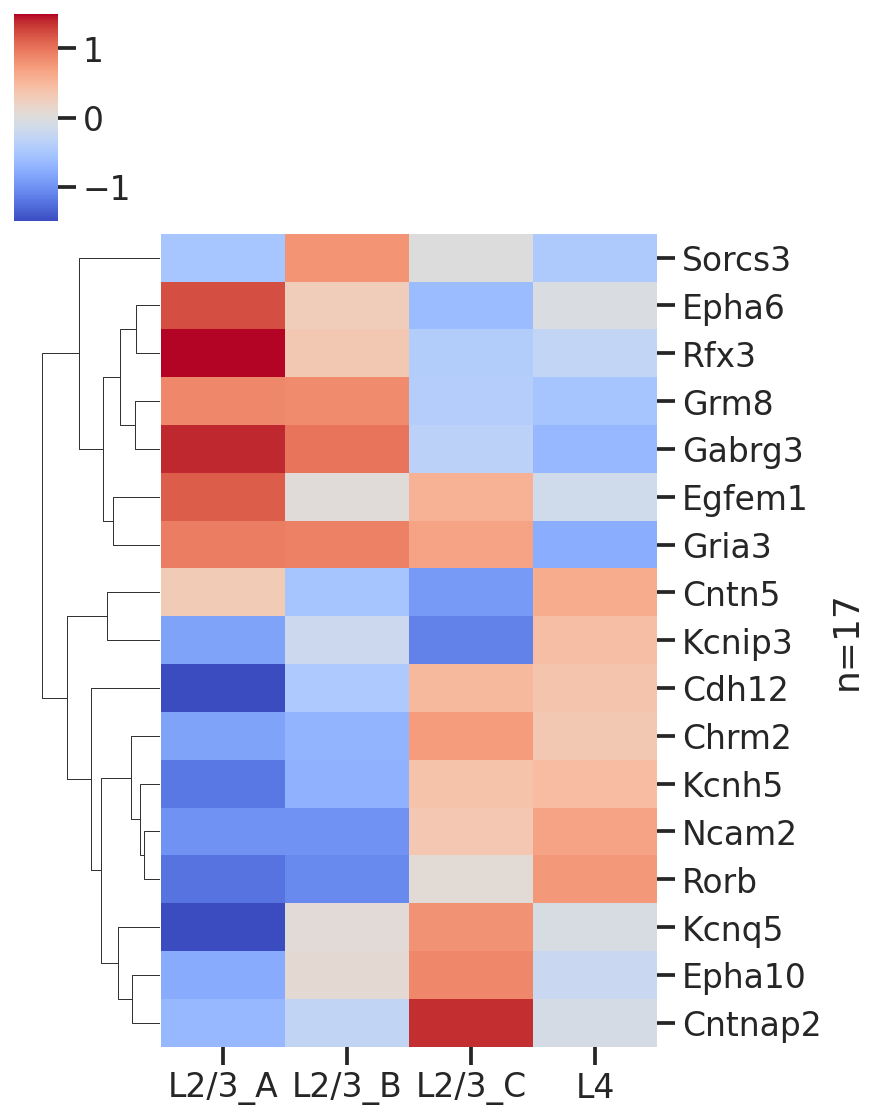

In [25]:
g = sns.clustermap(X_s,
                col_cluster=False,
                cmap='coolwarm',
                center=0,
                vmax=1.5, vmin=-1.5,
                # vmax=2, vmin=-2,
                figsize=(6,8), 
               )
g.ax_heatmap.set_ylabel(f'n={len(X_s)}')
plt.show()

In [32]:
# save the gene list
output = os.path.join(data_dir, 'genes_lasso_nonallen_May13.csv')
print(output)
Xannot[cond].to_csv(output, index=True)

/bigstore/GeneralStorage/fangming/projects/visctx/data_dump/genes_lasso_nonallen_May13.csv


In [26]:
# gene_order = [
#     'Cdh13',
#     'Adamts2',
#     'Nr4a3',
#     'Gabrg3',
#     'Gpc6',
    
#     'Sorcs3',
#     # 'Igfn1',
#     # 'Stard8',
#     # 'Epha10',
#     'Kcnq5',
    
#     'Cntnap2',
#     'Cdh12',
#     'Chrm2',
    
#     'Rorb',
#     'Ncam2',
    
#     'Cntn5',
    
#     'Kcnip3',
#     'Gria3',
# ]
# print(len(gene_order))
# print(np.sort(gene_order))

# fig, ax = plt.subplots(figsize=(4,6))
# Xp = X_s.reindex(gene_order).dropna()
# print(Xp.shape)
# sns.heatmap(Xp,
#             cmap='coolwarm',
#             center=0,
#             vmax=1.5, vmin=-1.5,
#             ax=ax,
#             cbar_kws=dict(label='z-scored log-normed expression')
#            )
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_gene_vs_type_heatmap.pdf'))
# plt.show()